In [1]:
import numpy as np
import pandas as pd
import torch
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.GCN import GCN
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
trn = pd.read_csv("../data/processed/trn.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.csv")

trn_y, trn_X = trn["Solubility"], trn["SMILES"]
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC["SMILES"]
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC["SMILES"]
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC["SMILES"]

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
trn_X = featurizer.convert(trn_X)
tst_08SC_X = featurizer.convert(tst_08SC_X)
tst1_19SC_X = featurizer.convert(tst1_19SC_X)
tst2_19SC_X = featurizer.convert(tst2_19SC_X)

In [5]:
tune_space = {
    "hidden_feats": hp.choice("hidden_feats",
                              [[64], [64, 64], [128, 64], [256, 128, 64],
                               [128, 128, 64], [256, 128, 128]]),
    "gnn_norm": hp.choice("gnn_norm", ['right', 'both', 'none']),
    "residual": hp.choice("residual", [True, False]),
    "batchnorm": hp.choice("batchnorm", [True, False]),
    "dropout": hp.uniform("dropout", 0, 1),
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "weight_decay": hp.uniform("weight_decay", 0, 1),

    "batch_size": 4096,
}

In [8]:
def tune_obj(space):
    kf = KFold(n_splits=3, shuffle=True)
    rmse = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GCN(
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=space["hidden_feats"],
            gnn_norm=space["gnn_norm"],
            activation=torch.nn.functional.relu,
            residual=space["residual"],
            batchnorm=space["batchnorm"],
            dropout=space["dropout"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=space["lr"],
            weight_decay=space["weight_decay"],
            batch_size=4096
        )

        scores = model.fit(tX, ty,
                           val_X=vX, val_y=vy,
                           epochs=800, min_epochs=500, early_stop_epochs=10, verbose=False)
        rmse.append(scores["rmse"][-1])

    return {"loss": np.mean(rmse), 'status': STATUS_OK}


In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

In [10]:
best_params

{'batchnorm': 1,
 'dropout': 0.07075484753350235,
 'gnn_norm': 1,
 'hidden_feats': 3,
 'lr': 2,
 'residual': 1,
 'weight_decay': 0.003975036016795143}

In [5]:
best_params = {
    "hidden_feats": [256, 128, 64],
    "gnn_norm": 'both',
    "residual": True,
    "batchnorm": True,
    "dropout": 0.07075484753350235,
    "lr": 0.001,
    "weight_decay": 0.003975036016795143,
    "batch_size": 4096,
}

In [6]:
kf = KFold(n_splits=10, shuffle=True)

pred_19t1, pred_19t2, pred_08t = [], [], []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X[trn_idx], trn_X[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]

    model = GCN(
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=best_params["hidden_feats"],
        gnn_norm=best_params["gnn_norm"],
        activation=torch.nn.functional.relu,
        residual=best_params["residual"],
        batchnorm=best_params["batchnorm"],
        dropout=best_params["dropout"],
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        batch_size=4096
    )

    scores = model.fit(
        tX, ty,
        val_X=vX, val_y=vy, epochs=800, min_epochs=400, early_stop_epochs=10)

    pred_validation = model.predict(vX).cpu()
    # print(f"{root_mean_squared_error(vy, pred_validation):.3f}, {r2_score(vy, pred_validation):.3f}")

    pred_19t1.append(model.predict(tst1_19SC_X).cpu())
    pred_19t2.append(model.predict(tst2_19SC_X).cpu())
    pred_08t.append(model.predict(tst_08SC_X).cpu())

 52%|█████▏    | 418/800 [00:25<00:23, 16.24it/s, trn_loss:0.018 val_loss:0.176 rmse:0.646 r2:0.901]


In [7]:
pred_19t1 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t1, 1)]
pred_19t2 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t2, 1)]
pred_08t = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_08t, 1)]

In [8]:
performance = {
    "2019SC TST1 (RMSE)": root_mean_squared_error(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (RMSE)": root_mean_squared_error(tst2_19SC_y, pred_19t2),
    "2008SC TST  (RMSE)": root_mean_squared_error(tst_08SC_y, pred_08t),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y, pred_19t2),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y, pred_08t),
}
performance

{'2019SC TST1 (RMSE)': 0.6843547520365596,
 '2019SC TST2 (RMSE)': 1.618519179558436,
 '2008SC TST  (RMSE)': 0.8738828395668311,
 '2019SC TST1 (R^2)': 0.6142753492842012,
 '2019SC TST2 (R^2)': 0.3488314798102585,
 '2008SC TST  (R^2)': 0.5853273659009409}

Text(0.5, 1.0, '08SC (GCN)   RMSE: 0.874, $R^2$: 0.585')

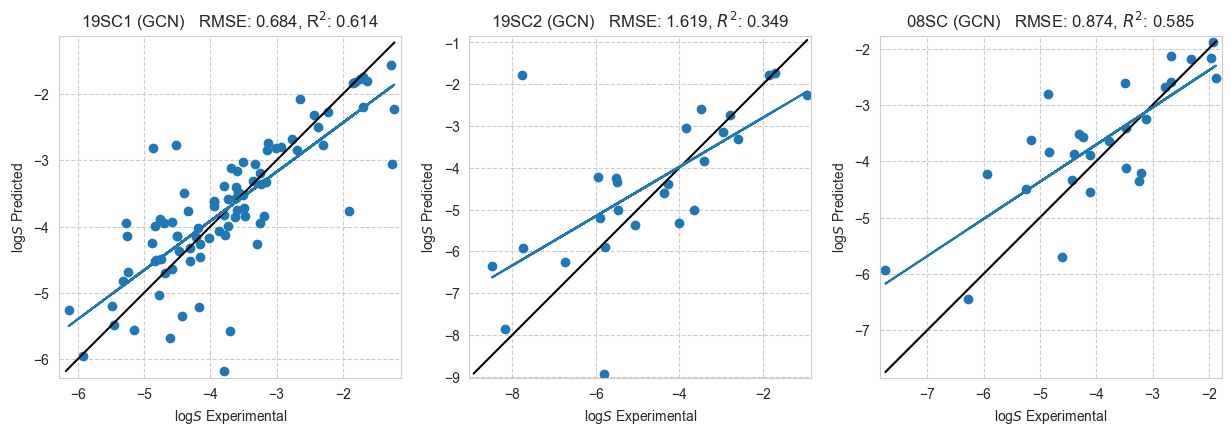

In [115]:
import matplotlib.pyplot as plt


def subplot(x, y, ax):
    ax.scatter(x, y)
    ax.set_xlim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    ax.set_ylim((min(min(x), min(y)) - 0.1, max(max(x), max(y)) + 0.1))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    ax.grid(which='major', linestyle='--')
    ax.plot([min(min(x), min(y)), max(max(x), max(y))], [min(min(x), min(y)), max(max(x), max(y))], 'k')
    a, b = np.polyfit(x, y, 1)
    y_fit = a * x + b
    ax.plot(x, y_fit)
    ax.set_xlabel("log$S$ Experimental")
    ax.set_ylabel("log$S$ Predicted")


model_name = "GCN"

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(5 * 3, 5))

subplot(tst1_19SC_y.values, pred_19t1, ax1)
subplot(tst2_19SC_y.values, pred_19t2, ax2)
subplot(tst_08SC_y.values, pred_08t, ax3)

ax1.set_title(f"19SC1 ({model_name})   "
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"R$^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"19SC2 ({model_name})   "
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"08SC ({model_name})   "
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")